# Формирование модели монетизации "Космические братья"

## Задачи, краткие выводы, описание

Сформируем модель монетизации игрового приложения.

Многие игры зарабатывают с помощью рекламы. И все они сталкиваются с противоречием:

- Пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет.
- Но  чем позже создатели игры включат рекламу, тем меньше они заработают.

Пока создатели игры планируют показывать её на экране выбором постройки. Поможем им не уйти в минус.

1. [Проведите исследовательский анализ данных](#Исследовательский-анализ-данных-(EDA)-4)
2. [Проанализируйте влияние событий на совершение целевого события](#Влияние-событий-на-совершение-целевого-события-5)
3. [Проверьте статистические гипотезы](#Проверка-статистических-гипотез-7)

---
Краткие выводы:

<b>42%</b> первых игроков выполнили целевое действие.

В среднем игроки завершают первый этап игры за <b>2 недели.</b>

При цене в 0.07 доллара за показ рекламы:
- Показывая рекламу <b>всем</b> и сразу, <u>получим прибыль</u> в размере <b>1891 долларов.</b>
- Если начать показывать рекламу <b>со второй постройки</b>, то <u>получим прибыль</u> в <b>400 долларов</b> на первом уровне.
- Но показывая рекламу <b>с третьей постройки</b>, <b><u>потеряем</u> 547 долларов.</b>

Предпочтительнее использовать модель показа рекламы со <b>второй постройки</b>, таким образом мы не отпугнем, только вступивших в игру, пользователей. 

<b>Стоит перераспределить расходы на привлечение пользователей в сторону YouTube и Яндекс.Директ</b>

---

Ссылка на презентацию: https://drive.google.com/file/d/1hYnDvhNgKG5XdHKSkluzAU719terg_ud/view?usp=sharing

Ссылка на дашборд: https://public.tableau.com/app/profile/andrey1394/viz/Cosmo-brothers_dashboard/Dashboard1

## Обновление и импорт библиотек.

In [1]:
!pip install matplotlib -U

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.3 MB 24 kB/s eta 0:00:01


In [2]:
!pip install seaborn -U

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 894 kB/s eta 0:00:01


In [3]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных и первый взгляд

In [4]:
game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

In [5]:
display(game_actions.head())
print(game_actions.info())
print('----------------------------------------------------')
print(game_actions.describe().T)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB
None
----------------------------------------------------
                 count  unique                                   top    freq
event_datetime  135640  128790                   2020-05-08 22:30:04       4
event           135640       3                              building  127957
building_type   127957       3                             spaceport   59325
user_id         135640   13576  d6aca06a-cd75-4cd8-b8cd-240a3c163884      22
project_type      1866       1            satellite_orbital_assembly    1866


Пропуски в данных обусловлены форматом записи ивентов. Если `event` не постройка, то в `building_type` будет пропуск. То же самое с `project_type` если `event` не `project`.  Заполять их не будем. Некоторым функциям проще работать с пропущенные значениями.

In [6]:
display(ad_costs)
print(ad_costs.describe())

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


             cost
count   28.000000
mean   271.556321
std    286.867650
min     23.314669
25%     66.747365
50%    160.056443
75%    349.034473
max    969.139394


Оплату за пользователей производили за день до фактического привлечения. Самые большие расходы на рекламу были в первый день выпуска soft launch, и снижались с каждый последующим днем.

In [7]:
display(user_source.head())
print(user_source.info())

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB
None


### Предобработка данных

In [8]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'], format='%Y-%m-%d %H:%M:%S')
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%d')

Откинем точное время ивента за ненадобностью. Оставим только год, месяц и день. 

In [9]:
game_actions[game_actions.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


В данных имеется один дубликат, похоже что произошел сбой в системе. Необходимо сообщить об этом разработчикам. Данный дубликат удалим, он всего один на 135 тысяч строк.

In [10]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

In [11]:
user_source[user_source.duplicated()]

,user_id,source


In [12]:
game_actions['event_datetime'] = game_actions['event_datetime'].astype('datetime64[D]')
reg_datetime = game_actions.groupby('user_id').agg(reg_datetime=('event_datetime', 'min')).reset_index()
game_actions = game_actions.merge(reg_datetime, on='user_id')

Откинем точное время ивента за ненадобностью. Оставим только год, месяц и день. 

## Исследовательский анализ данных (EDA)

In [13]:
game_actions['event_datetime'].max() - game_actions['event_datetime'].min()

Timedelta('32 days 00:00:00')

Всего данных за 32 дня

In [14]:
game_actions.groupby('event')['user_id'].count()

event
building            127956
finished_stage_1      5817
project               1866
Name: user_id, dtype: int64

Всего за месяц 13576 игроков построили 127956 строений. В среднем, каждый из них построил по 9,5 зданий. Только 5817 пользователей завершили первый этап, остальные 7759 либо предпочли не завершать уровень(в игре есть возможность остаться на первом уровне, даже после завершения проекта или победы над игроком), либо отвалились. 

In [15]:
users_reg_date = game_actions[['reg_datetime', 'user_id']].drop_duplicates()

In [16]:
users_reg_date.head()

,reg_datetime,user_id
0,2020-05-04,55e92310-cb8e-4754-b622-597e124b03de
7,2020-05-04,c07b1c10-f477-44dc-81dc-ec82254b1347
20,2020-05-04,6edd42cc-e753-4ff6-a947-2107cd560710
33,2020-05-04,92c69003-d60a-444a-827f-8cc51bf6bf4c
43,2020-05-04,cdc6bb92-0ccb-4490-9866-ef142f09139d


In [17]:
def sns_histplot(df, x, cumulative, title, ylabel, xlim, nloc, rotation):
    sns.set(style='white')
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1,1,1)  
    sns.histplot(data=df, x=x, cumulative=cumulative, discrete=True, ax=ax)
    plt.title(title, loc='left', fontsize=18)
    ax.set_xlim(xlim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.xaxis.set_major_locator(plt.MaxNLocator(nloc))
    ax.tick_params(axis='x', rotation=rotation)
    plt.show()

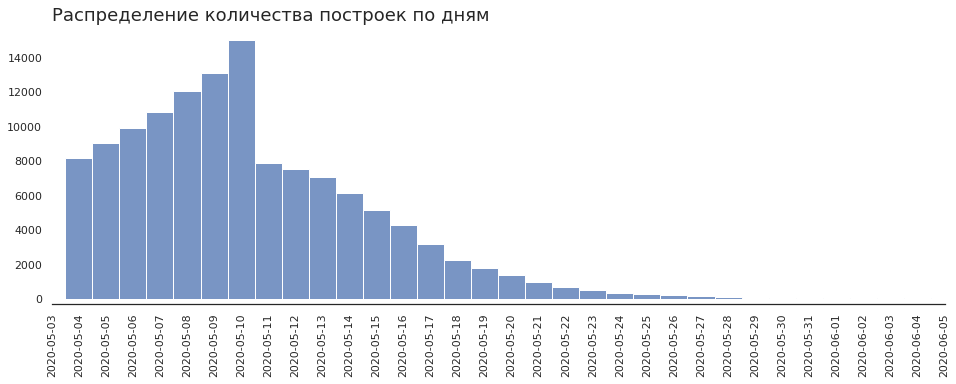

In [18]:
df_buildings = game_actions[game_actions['event']=='building']

sns_histplot(df = df_buildings, 
             x = 'event_datetime', 
             cumulative = False, 
             title = 'Распределение количества построек по дням', 
             ylabel = 'Количество игроков',
             xlim = (min(game_actions['event_datetime'])-pd.Timedelta(days=1),max(game_actions['event_datetime'])),
             nloc=33,
             rotation=90)

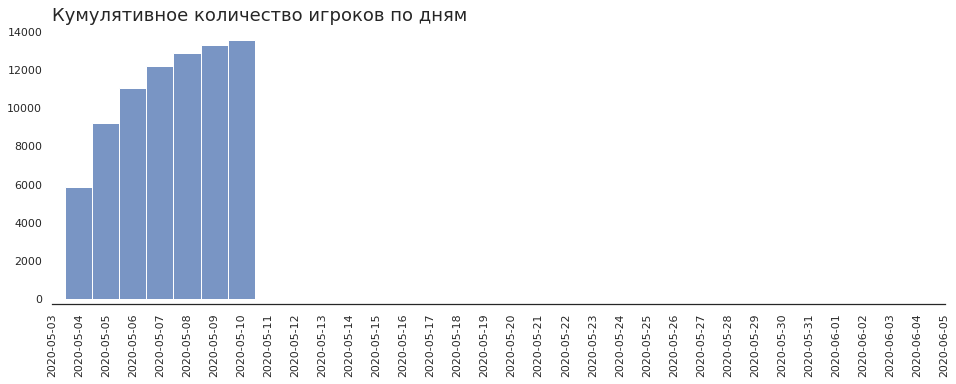

In [19]:
sns_histplot(df = users_reg_date, 
             x = 'reg_datetime', 
             cumulative = True, 
             title = 'Кумулятивное количество игроков по дням', 
             ylabel = 'Количество игроков', 
             xlim = (min(game_actions['event_datetime'])-pd.Timedelta(days=1),max(game_actions['event_datetime'])),
             nloc=33,
             rotation=90
            )

Количество построек растет с ростом числа игроков. График кумулятивного количества пользователей построен по той же оси Х, что и график распределения количества построек, для более наглядного понимания, почему 11.05 происходит падение и дальнейшее снижение построек.

После завершения привлечения новых пользователей, количество построек резко падает на 7000 единиц и продолжает снижаться. Не удивительно, ведь игроки строят необходимые объекты и проходят дальше.

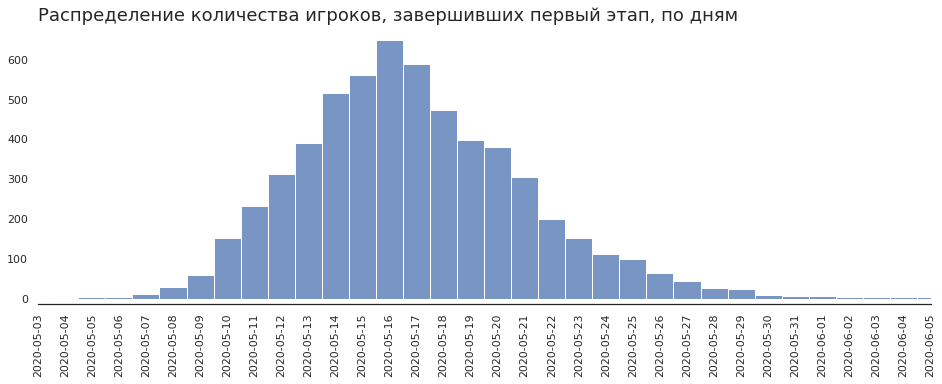

In [20]:
df_finished = game_actions[game_actions['event']=='finished_stage_1']
sns_histplot(df = df_finished, 
             x = 'event_datetime',
             cumulative = False, 
             title = 'Распределение количества игроков, завершивших первый этап, по дням', 
             ylabel = 'Количество игроков',
             xlim = (min(game_actions['event_datetime'])-pd.Timedelta(days=1),max(game_actions['event_datetime'])),
             nloc=33,
             rotation=90
            )

Некоторые игроки завершили первый этап уже на следующий день, после запуска игры. На 13 день, с момента запуска игры, приходится пик игроков завершивших первый этап. 

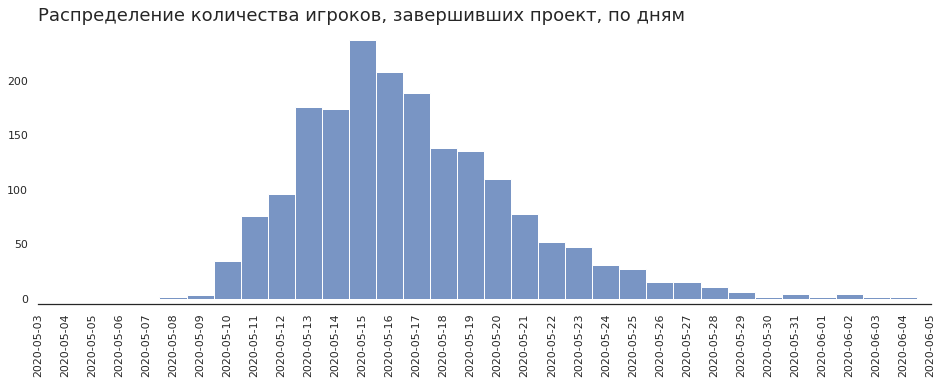

In [21]:
df_project = game_actions[game_actions['event']=='project']
sns_histplot(df = df_project, 
             x = 'event_datetime', 
             cumulative = False, 
             title = 'Распределение количества игроков, завершивших проект, по дням', 
             ylabel = 'Количество игроков',
             xlim = (min(game_actions['event_datetime'])-pd.Timedelta(days=1),max(game_actions['event_datetime'])),
             nloc=33,
             rotation=90
            )

Первые проекты завершились спустя 5 дней, после запуска игры. Пик количества построенных орбитальных станций приходится на 12 день, после запуска игры.

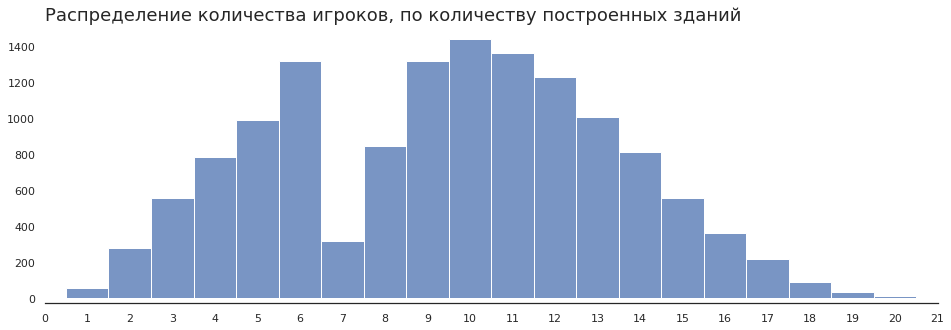

In [22]:
df_users_building = game_actions.groupby(['user_id']).agg(building_cnt=('building_type', 'count')).reset_index()

sns_histplot(df = df_users_building, 
             x = 'building_cnt',
             cumulative = False, 
             title = 'Распределение количества игроков, по количеству построенных зданий', 
             ylabel = 'Количество игроков',
             xlim = (0, 21),
             nloc=21,
             rotation=0)

Наблюдается небольшой провал в 7 и 8 зданий. Возможно 6 зданий достаточно для победы в PvP, а для постройки орбитальной станции необходимо 9+ зданий.

## Влияние событий на совершение целевого события

In [23]:
release_project = game_actions.loc[game_actions['project_type'].notna()]

In [24]:
len(release_project)

1866

Всего 1866 игроков реализовали проект. 

### Победа над первым врагом

In [25]:
finish_stage_win = game_actions.loc[(game_actions['event']=='finished_stage_1')&
                                (~game_actions['user_id'].isin(release_project['user_id']))
                               ]

In [26]:
finish_stage_win_buildings_cnt = (game_actions[game_actions['user_id'].isin(finish_stage_win['user_id'])
                                              ]
                                  .groupby('user_id')['building_type']
                                  .count()
                                  .reset_index()
                                 )

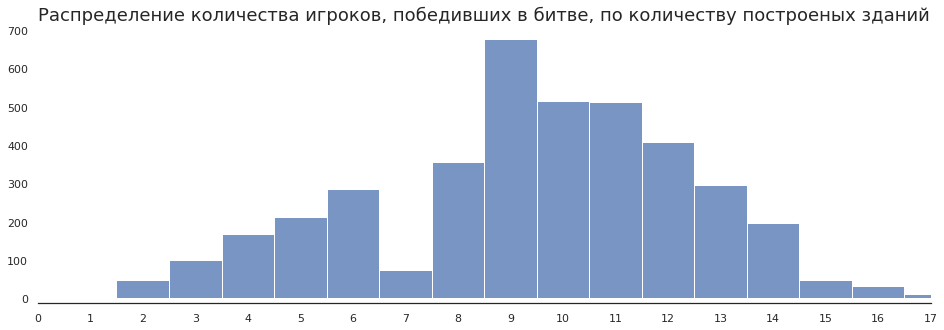

In [27]:
sns_histplot(df = finish_stage_win_buildings_cnt, 
             x = 'building_type',
             cumulative = False, 
             title = 'Распределение количества игроков, победивших в битве, по количеству построеных зданий', 
             ylabel = 'Количество игроков',
             xlim = (0, 17),
             nloc=17,
             rotation=0)

Игроки построившие только 2 здания уже имеют возможность пройти первый этап игры. Пик количества построек с помощью которых игроки, побеждают в битве и проходят первый этап, приходится на 9 зданий. 

In [28]:
finish_stage_win['timedelta_finish_start'] = ((finish_stage_win['event_datetime'] - finish_stage_win['reg_datetime'])
                                              .dt.total_seconds() / 86400
                                             ).round()

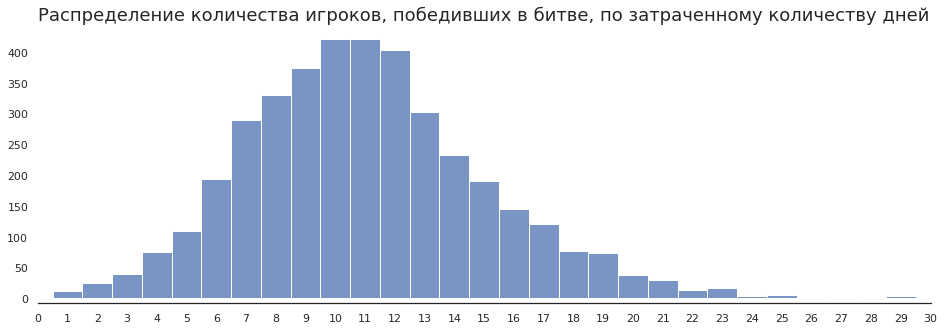

Игроков завершивших этап победой над врагом: 3951
% Игроков завершивших этап победой над врагом: 0.2910282852091927


In [29]:
sns_histplot(df = finish_stage_win, 
             x = 'timedelta_finish_start',
             cumulative = False, 
             title = 'Распределение количества игроков, победивших в битве, по затраченному количеству дней', 
             ylabel = 'Количество игроков',
             xlim = (0, 30),
             nloc=30,
             rotation=0)

print('Игроков завершивших этап победой над врагом:', len(finish_stage_win))
print('% Игроков завершивших этап победой над врагом:', len(finish_stage_win) / len(user_source))

Всего 3951 или 29% игроков одержали победу над первым врагом и перешли на следующий уровень.
Некоторые игроки уже на второй день проходили первый этап игры, победой над врагом. Вот это скорость. 
В среднем, игроки проходят первый этап победой над врагом за 10-11 дней.

### Реализация проекта - разработка орбитальной сборки спутников

In [30]:
finish_stage_project = game_actions.loc[(game_actions['event']=='finished_stage_1')&
                                        (game_actions['user_id'].isin(release_project['user_id']))
                                       ]

In [31]:
finish_stage_project_buildings_cnt = (game_actions[game_actions['user_id'].isin(finish_stage_project['user_id'])
                                              ]
                                  .groupby('user_id')['building_type']
                                  .count()
                                  .reset_index()
                                 )

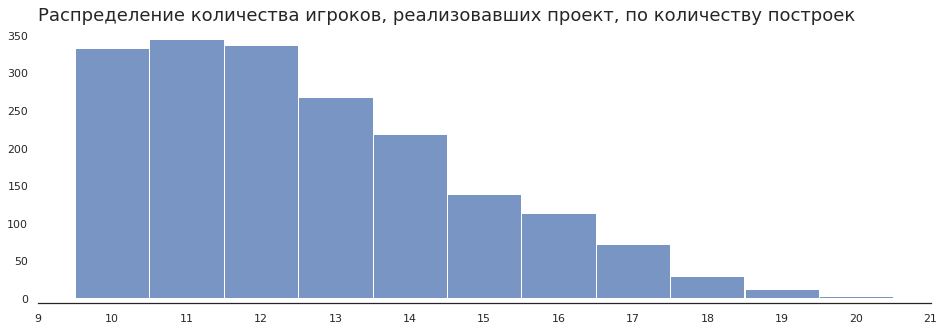

In [32]:
sns_histplot(df = finish_stage_project_buildings_cnt, 
             x = 'building_type',
             cumulative = False, 
             title = 'Распределение количества игроков, реализовавших проект, по количеству построек', 
             ylabel = 'Количество игроков',
             xlim = (9, 21),
             nloc=12,
             rotation=0)

Предыдущее наблюдение о необходимом количестве зданий, для реализации проекта, подтверждается. Для постройки орбитальной станции, необходимо возвести минимум 10 зданий. 

In [33]:
finish_stage_project['timedelta_finish_start'] = ((finish_stage_project['event_datetime'] - finish_stage_project['reg_datetime'])
                                              .dt.total_seconds() / 86400
                                             ).round()

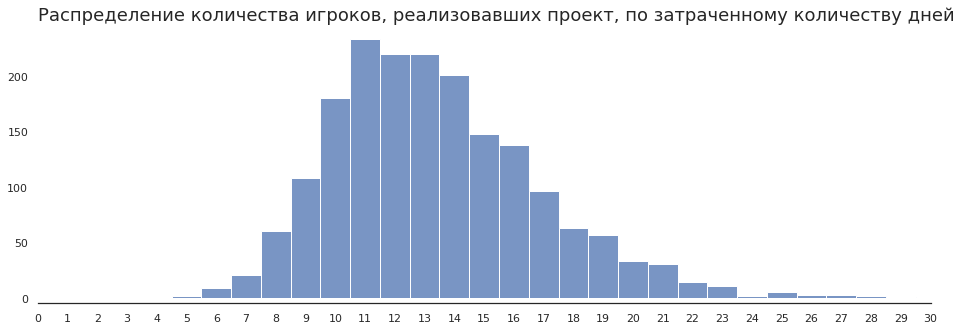

Игроков завершивших этап победой над врагом: 1866
% Игроков завершивших этап победой над врагом: 0.13744843842074247


In [34]:
sns_histplot(df = finish_stage_project, 
             x = 'timedelta_finish_start',
             cumulative = False, 
             title = 'Распределение количества игроков, реализовавших проект, по затраченному количеству дней', 
             ylabel = 'Количество игроков',
             xlim = (0, 30),
             nloc=33,
             rotation=0)

print('Игроков завершивших этап победой над врагом:', len(finish_stage_project))
print('% Игроков завершивших этап победой над врагом:', len(finish_stage_project) / len(user_source))

Для реализации проекта игрокам требуется минимум 5 дней. В среднем 11 дней.
Все 1866 игроков реализовавших проект, закончили первый этап. 13% всех игроков, завершили уровень разработкой орбитальной сборки спутников. 

## Изучение модели монетизации

### Текущие расходы

In [35]:
user_source = user_source.merge(game_actions[['reg_datetime', 'user_id']].drop_duplicates(), 
                                on='user_id')

user_source['reg_datetime'] = user_source['reg_datetime'].astype('datetime64[D]')

cnt_user_source_reg = (user_source.groupby(['source', 'reg_datetime'])
                       .agg(user_cnt=('user_id', 'count'))
                       .reset_index()
                      )

ad_costs['day'] = ad_costs['day'] + pd.Timedelta(days=1)

ad_costs = ad_costs.merge(cnt_user_source_reg, 
                          left_on=['source', 'day'], 
                          right_on=['source', 'reg_datetime'])

In [36]:
ad_costs['cac'] = ad_costs['cost'] / ad_costs['user_cnt']

In [37]:
def ad_costs_plots(df, y, title, ylabel, legend_title, loc, bbox):
    fig = plt.figure(figsize=(16,5))
    sns.set(style='white')
    ax = sns.lineplot(data=df, x='day', y=y, hue='source', marker='o')
    plt.title(title, loc='left', fontsize=18)
    plt.legend(loc=loc, 
           title=legend_title,
           bbox_to_anchor=bbox)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.show()

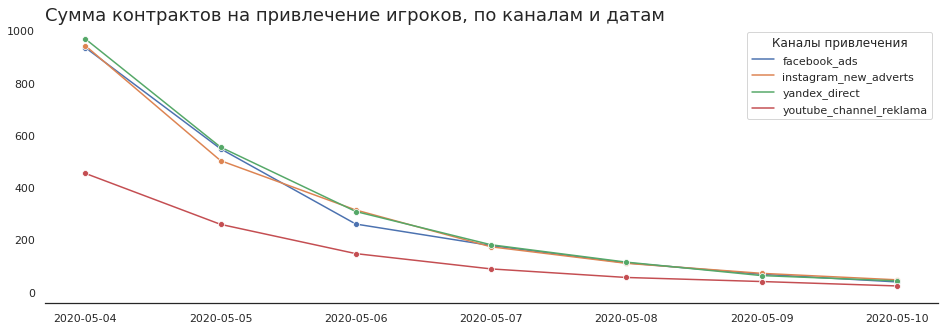

In [38]:
ad_costs_plots(df=ad_costs, 
               y='cost', 
               title='Сумма контрактов на привлечение игроков, по каналам и датам', 
               ylabel='Сумма, $', 
               legend_title='Каналы привлечения',
               loc='upper right',
               bbox=(1,1),
              )

Все контракты, кроме YouTube, были заключены примерно на одни суммы. Сумма контракта с YouTube в 2 раза ниже остальных.  

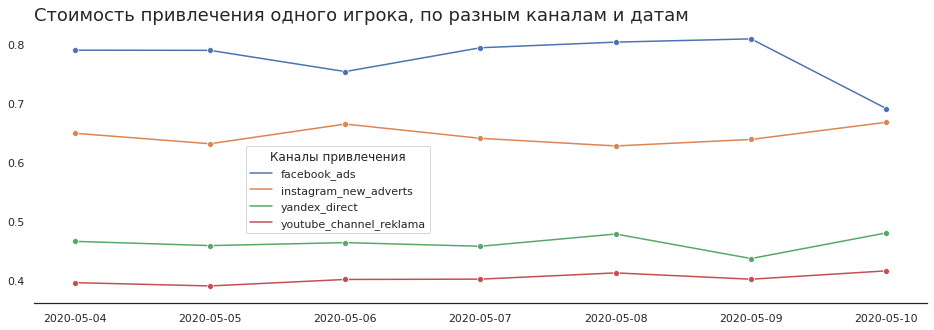

In [39]:
ad_costs_plots(df=ad_costs, 
               y='cac', 
               title='Стоимость привлечения одного игрока, по разным каналам и датам', 
               ylabel='Стоимость, $', 
               legend_title='Каналы привлечения',
               loc='center right',
               bbox=(0.45,0.4))

CAC на YouTube самый низкий, возможно поэтому и сумма контракта ниже остальных. Facebook самый дорогой, интересно, как много игроков он привлекает? 

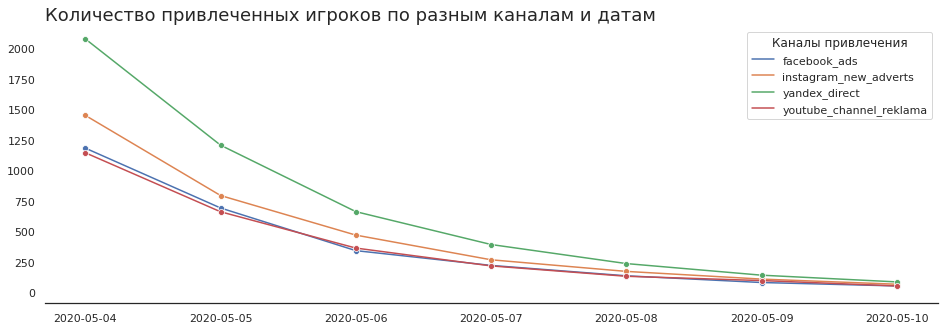

In [40]:
ad_costs_plots(df=ad_costs, 
               y='user_cnt', 
               title='Количество привлеченных игроков по разным каналам и датам', 
               ylabel='Количество привлеченных игроков', 
               legend_title='Каналы привлечения',
               loc='upper right',
               bbox=(1,1))

А вот и ответ. Дорогой не значит хороший! Facebook привлек почти столько же игроков, сколько и самый дешевый YouTube. Яндекс.Директ чуть дороже YouTube, но выделено средств на него было столько же, сколько на Instagram, а привлек Директ сильно больше других каналов. 

Стоит перераспределить расходы на привлечение пользователей в сторону YouTube и Яндекс.Директ

In [41]:
ad_costs['cost'].sum()

7603.576986788022

In [42]:
ad_costs['cost'].sum() / user_source['user_id'].count()

0.5600749106355349

На привлечение первых пользователей было потрачено 7603,5 доллара. 

В среднем, за каждого пользователя компания заплатила 0.56 доллара. Возьмем среднюю стоимость привлечения по всем каналам, не будем же мы показывать разное количество рекламы пользователям, пришедшим из разных источников. 

### Расчет потенциальной выручки

In [43]:
game_actions = game_actions.sort_values(by='event_datetime', ascending=True)

game_actions['building_id'] = np.where(
    game_actions['building_type'].isna(), 
    0,
    1
)
game_actions['building_id'] = (game_actions.sort_values(['event_datetime', 'user_id'])
                               .groupby('user_id')
                               .building_id.apply(lambda x : x.groupby(x.ne(1).cumsum()).cumcount()+1)
                              )

game_actions['building_id'] = np.where(
    game_actions['building_type'].isna(), 
    0,
    game_actions['building_id']
)

In [44]:
game_actions['all_buildings'] = np.where(
    game_actions['building_id']==0, 
    np.nan,
    0.07
)
game_actions['all_buildings'] = game_actions['all_buildings'].cumsum()

In [45]:
game_actions['after_first_building'] = np.where(
    game_actions['building_id']==0, 
    np.nan,
    np.where(game_actions['building_id']<=1, np.nan, 0.07)
)
game_actions['after_first_building'] = game_actions['after_first_building'].cumsum()

In [46]:
game_actions['after_second_building'] = np.where(
    game_actions['building_id']==0, 
    np.nan,
    np.where(game_actions['building_id']<=2, np.nan, 0.07)
)
game_actions['after_second_building'] = game_actions['after_second_building'].cumsum()

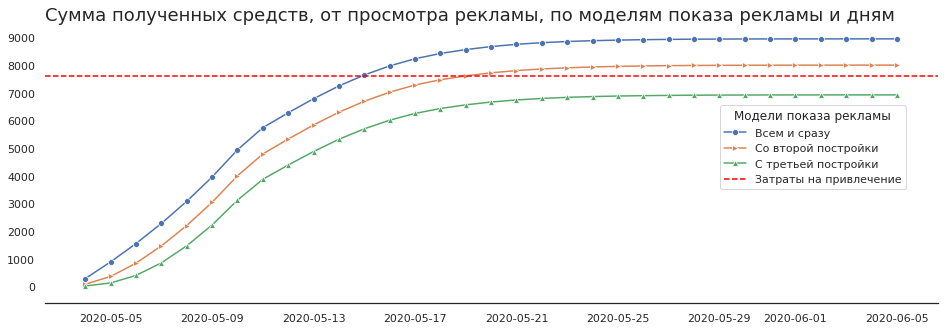

In [47]:
fig = plt.figure(figsize=(16,5))
sns.set(style='white')

ax = sns.lineplot(data=game_actions,
                  x='event_datetime',
                  y='all_buildings', 
                  ci=None,
                  marker='o'
                 )

ax = sns.lineplot(data=game_actions,
                  x='event_datetime', 
                  y='after_first_building', 
                  ci=None, 
                  marker='>'
                 )

ax = sns.lineplot(data=game_actions,
                  x='event_datetime', 
                  y='after_second_building', 
                  ci=None,
                  marker='^'
                 )

ax.axhline(ad_costs['cost'].sum(), 
           color='red', 
           ls='--')

ax.legend(['Всем и сразу', 'Со второй постройки', 'С третьей постройки', 'Затраты на привлечение'], 
          loc='upper left',
          title='Модели показа рекламы',
          bbox_to_anchor=(0.75,0.73)
         )

plt.title('Сумма полученных средств, от просмотра рекламы, по моделям показа рекламы и дням', loc='left', fontsize=18)
plt.xlabel('')
plt.ylabel('Сумма, $')
plt.yticks(np.arange(0, 10000, step=1000))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

При цене в 0.07 доллара за показ рекламы:
<br> - Показывая рекламу всем и сразу, получим прибыль в размере 1891 долларов.
<br> - Если начать показывать рекламу после первой постройки, то получим прибыль в 400 долларов на первом уровне.
<br> - Но показывая рекламу после второй постройки, потеряем 547 долларов.

## Проверка статистических гипотез

### H<sub>0</sub> - время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, равно.

H<sub>1</sub> - время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, различается.

In [48]:
timedelta_reg_project = (finish_stage_project['event_datetime'] - finish_stage_project['reg_datetime']).dt.total_seconds()

In [49]:
timedelta_reg_win = (finish_stage_win['event_datetime'] - finish_stage_win['reg_datetime']).dt.total_seconds()

In [50]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.mannwhitneyu(timedelta_reg_project, timedelta_reg_win, alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.786610358453673e-105
Отвергаем нулевую гипотезу


Отвергаем гипотезу о равенстве времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

Есть статистически значимые различия. 

### H<sub>0</sub> - количество построек пользователей, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, равно.

H<sub>1</sub> - количество построек пользователей, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, различается.

In [51]:
buildings_project = (game_actions[game_actions['user_id'].isin(finish_stage_project['user_id'])]
                          .groupby('user_id')['building_type']
                          .count()
                    .reset_index(drop=True))

In [52]:
buildings_win = (game_actions[game_actions['user_id'].isin(finish_stage_win['user_id'])]
                          .groupby('user_id')['building_type']
                          .count()
                          .reset_index(drop=True))

In [53]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.mannwhitneyu(buildings_project, buildings_win, alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 5.211926275022306e-305
Отвергаем нулевую гипотезу


Отвергаем гипотезу о равенстве количества построек пользователей, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

Есть статистически значимые различия.

## Выводы

Выгруженные данные очень качественные, с одной лишь проблемой - одним дубликатом.

Всего за месяц <b>13576</b> игроков построили <b>127956</b> строений. В среднем, каждый из них построил по 9 зданий. 
<br>Только <b>5817 пользователей завершили первый этап</b>, остальные <b>7759</b> либо предпочли не завершать уровень(в игре есть возможность остаться на первом уровне, даже после завершения проекта или победы над игроком), либо отвалились.

После заврешения привлечения новых пользователей, количество построек резко падает на 7000 единиц и продолжает снижаться. Не удивительно, ведь игроки строят необходимые объекты и проходят дальше.

<b>В среднем игроки завершают первый этап игры за 2 недели.</b>

Некоторые игроки завершили первый этап уже на следующий день, после запуска игры. На 13 день, с момента запуска игры, приходится пик игроков завершивших первый этап.

Игроки построившие только 2 здания уже имеют возможность пройти первый этап игры, победой над врагом. Пик количества построек с помощью которых игроки, побеждают в битве и проходят первый этап, приходится на 9 зданий.
Для построения орбитальной станции, необходимо возвести минимум 10 зданий.

Всего 1866 игроков реализовали проект.

<b>3951 или 29% игроков</b> одержали <b>победу над первым врагом</b> и перешли на следующий уровень.

<b>Все 1866 игроков реализовавших проект, закончили первый этап.</b> 13% всех игроков, завершили уровень разработкой орбитальной сборки спутников.

На <b>привлечение</b> первых пользователей было потрачено <b>7603,5 доллара.</b>

В среднем, за каждого пользователя <b>компания заплатила 0.56 доллара.</b> 

Facebook привлек почти столько же игроков, сколько и самый дешевый YouTube. Яндекс.Директ чуть дороже YouTube, но выделено средств на него было столько же, сколько на Instagram, а привлек Директ сильно больше других каналов.

Стоит перераспределить расходы на привлечение пользователей в сторону YouTube и Яндекс.Директ

При цене в 0.07 доллара за показ рекламы:
- Показывая рекламу <b>всем</b> и сразу, <u>получим прибыль</u> в размере <b>1891 долларов.</b>
- Если начать показывать рекламу <b>со второй постройки</b>, то <u>получим прибыль</u> в <b>400 долларов</b> на первом уровне.
- Но показывая рекламу <b>с третьей постройки</b>, <b><u>потеряем</u> 547 долларов.</b>

